
# Toxic Comment Classification

This is a template notebook for Toxic Comment Classification project (CMPT413).


## Install dependencies and initialization

In [1]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1

In [2]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

/content
'=2.0.1'   sample_data
Wed Dec  8 04:33:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

In [3]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os
import io
import h5py
import shutil
import string

#Keras
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.optimizer import Optimizer
import torchtext
import torch

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# Make sure that GPU is available for notebook.
torch.cuda.is_available()

True

In [5]:
# Mount google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define the location of current directory, which should contain data/train, data/test.
os.chdir("drive/My Drive/CMPT413_toxic_comments_project")
BASE_DIR = 'toxic_comments_output'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
GLOVE_DIR = 'data/glove/glove.6B.100d.retrofit.txt'
EMBEDDING_DIM = 100
max_features=20000
max_len=100
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [7]:
#!unzip "data/train.csv.zip" -d "data"
#!unzip "data/test.csv.zip" -d "data/test"
#!unzip "data/test_labels.csv.zip" -d "data/test"

## Preprocessing:

In [8]:
stopwords_en = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text,remove_stopwords=True, remove_repeat_text=True):
    # -- Converting to lower case
    text = text.lower()
    
    # replacing english abbreviations with full forms
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    
    if remove_repeat_text:
        text = re.sub(r'(.)\1{2,}', r'\1', text) 

    if(remove_stopwords):
        # -- Lemmatization and segmentation
        filtered_sent = []
        sent = nltk.word_tokenize(text) #word tokenizing
        for i in sent:
            # -- Removing stopwords
            if i not in stopwords_en:
                filtered_sent.append(lemmatizer.lemmatize(i))
        text = ','.join(filtered_sent)
    
    # -- Removing numbers
    retokenizer1 = RegexpTokenizer(r'\D+') #remove numerical values
    text = ','.join(retokenizer1.tokenize(text))
    
    # -- Removing punctuations
    retokenizer2 = RegexpTokenizer(r'\w+') #remove numerical values
    text = ' '.join(retokenizer2.tokenize(text))
    
    return text

In [9]:
df = pd.read_csv('data/train.csv')
pd.set_option('display.max_colwidth', None)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [10]:
df['comment_text'] = df['comment_text'].map(lambda txt : clean_text(txt))
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seemingly stuck thanks talk january utc,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good_article_nominations transport,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


In [11]:
train_dataset, val_dataset = train_test_split(df, random_state=1) #train = 0.75, val = 0.25
train_dataset.to_csv("data/train/train.csv")
val_dataset.to_csv("data/val/val.csv")

In [12]:
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

train_labels = train_dataset[toxic_labels].values
comments_train = train_dataset['comment_text']
comments_train = list(comments_train)

val_labels = val_dataset[toxic_labels].values
comments_val = val_dataset['comment_text']
comments_val = list(comments_val)

df_test_labels = pd.read_csv('data/test/test_labels.csv')
test_labels = df_test_labels[toxic_labels].values
test_labels = (test_labels != 0).astype(float)

In [13]:
train_texts = []
for line in tqdm(comments_train, total=119678):
  train_texts.append(line)

val_texts = []
for line in tqdm(comments_val, total=39893):
  val_texts.append(line)

df = pd.read_csv('data/test/test.csv')
df['comment_text'] = df['comment_text'].map(lambda txt : clean_text(txt))
comments_test = df['comment_text']

test_texts = []
for line in tqdm(comments_test, total=153164):
  test_texts.append(line)

  0%|          | 0/119678 [00:00<?, ?it/s]

  0%|          | 0/39893 [00:00<?, ?it/s]

  0%|          | 0/153164 [00:00<?, ?it/s]

In [14]:
tokenizer = Tokenizer(num_words=max_features,lower= True)
tokenizer.fit_on_texts(list(comments_train))
word_index = tokenizer.word_index

tokenized_train=tokenizer.texts_to_sequences(comments_train)
tokenized_test=tokenizer.texts_to_sequences(comments_test)
tokenized_val=tokenizer.texts_to_sequences(comments_val)

train_texts=pad_sequences(tokenized_train,maxlen=max_len)
test_texts=pad_sequences(tokenized_test,maxlen=max_len)
val_texts=pad_sequences(tokenized_val,maxlen=max_len)

In [15]:
i=12
print(comments_train[i])
print(train_texts[i])

ok sorry keep trying tnx reminder may noticed soon actually comprehend policy try follow still comment though copyright line issue educational purpose would appear cover context bow yr claim valid note original discussion inclusion line hamsun obituary hitler reason deletion copyright deleter want text claiming irrelevant entry copyright permission due course obtained monday hope support inclusion obituary entry incidentally approx many editor writing
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0   337   172   125   153  4128    20   501   566   123  5571
    73   174   548    76    37   148   141   290    81  3148   576     5
   581   652   580  5388  5779   130   664    91   203    52   797   290
 17542  8156  1558    71    38   141 18535    30   158  1169   881   348
   141  1012   457   307  3009  4

### GloVe

In [16]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loading GloVe from: data/glove/glove.6B.100d.retrofit.txt ...Found 400000 word vectors.


In [17]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02328654  0.01661578  0.0347484  ... -0.08114112  0.03868156
   0.0362244 ]
 [-0.04174801  0.00954155  0.02114576 ... -0.04753175  0.03944544
   0.02908922]
 ...
 [ 0.0742953  -0.0319478  -0.0733457  ...  0.2241829  -0.0217099
  -0.038797  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.05068332  0.05030753  0.00888725 ...  0.02128703  0.00471647
   0.05786167]]


In [18]:
i = 3
print(comments_train[i])
print(train_texts[i])
train_labels[i]

album eps mixtapes gave list reliable source gave one elektric blue lovechild new album gave source mixtapes eps prof valuable apart profile discography get source provide shortly
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   629 12631   817    68   169     9   817
     6  1150    46   629   817     9 12631  1772  2314  1997  1885  3203
    22     9   345  1434]


array([0, 0, 0, 0, 0, 0])

##Keras

###Model

In [ ]:
#Baseline with GloVe
inp = Input(shape=(max_len,), dtype='int32')
x = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = 100, trainable=False,)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
preds = Dense(6, activation="sigmoid")(x)

model = Model(inp, preds)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
plot_model(model)

AttributeError: ignored

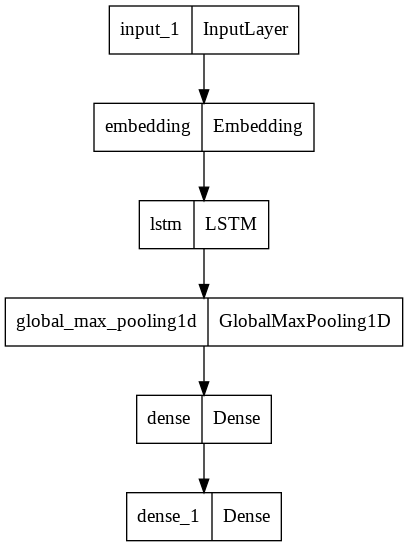

In [ ]:
#Baseline with GloVe and one (100, 50) fully connected layer
inp = Input(shape=(max_len,), dtype='int32')
x = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = 100, trainable=False,)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
preds = Dense(6, activation="sigmoid")(x)

model = Model(inp, preds)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
plot_model(model)

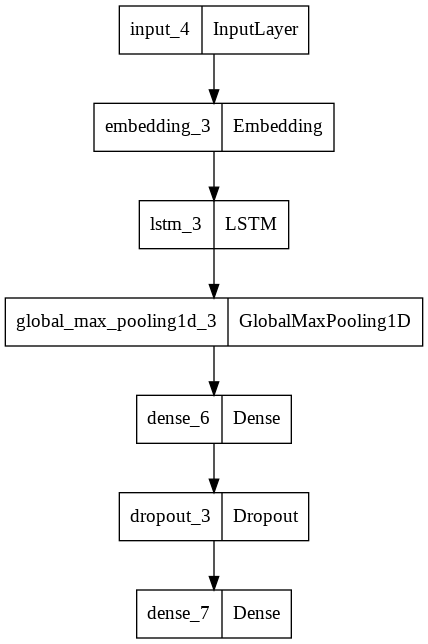

In [ ]:
#Baseline with GloVe and one (100, 50) fully connected layer and one dropout layer 0.1
inp = Input(shape=(max_len,), dtype='int32')
x = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = 100, trainable=False,)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

model = Model(inp, preds)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
plot_model(model)

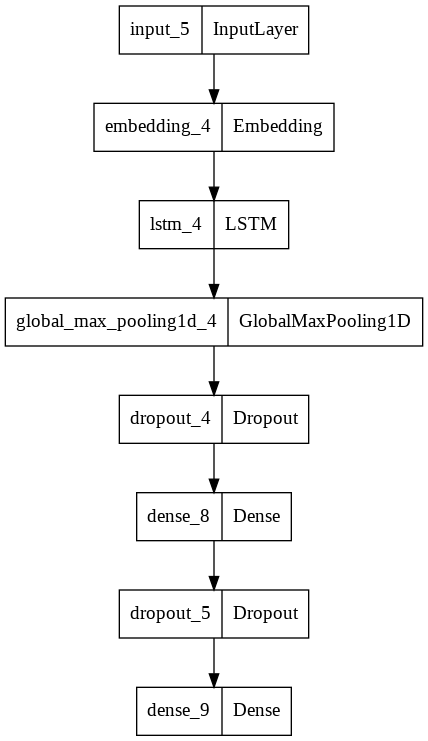

In [ ]:
#Baseline with GloVe and one (100, 50) fully connected layer and two dropout layers 0.1
inp = Input(shape=(max_len,), dtype='int32')
x = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix], input_length = 100, trainable=False,)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

model = Model(inp, preds)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
plot_model(model)

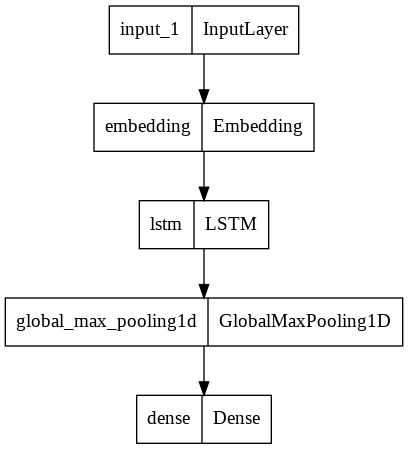

In [19]:
#No GloVe baseline model
inp = Input(shape=(max_len,))
x = Embedding(max_features,EMBEDDING_DIM)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
preds = Dense(6,activation="sigmoid") (x)

model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])
plot_model(model)

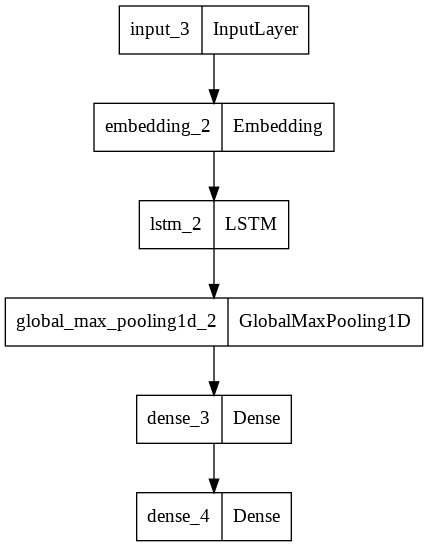

In [23]:
#No GloVe baseline model and one (100, 50) fully connected layer
inp = Input(shape=(max_len,))
x = Embedding(max_features,EMBEDDING_DIM)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
preds = Dense(6,activation="sigmoid") (x)

model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])
plot_model(model)

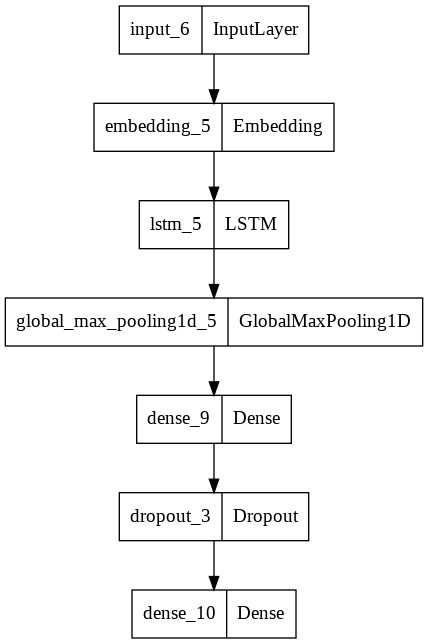

In [32]:
#Best model - No GloVe baseline model and one (100, 50) fully connected layer with dropout layer 0.1
inp = Input(shape=(max_len,))
x = Embedding(max_features,EMBEDDING_DIM)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(50,activation="relu") (x)
x = Dropout(0.1)(x)
preds = Dense(6,activation="sigmoid") (x)

model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])
plot_model(model)

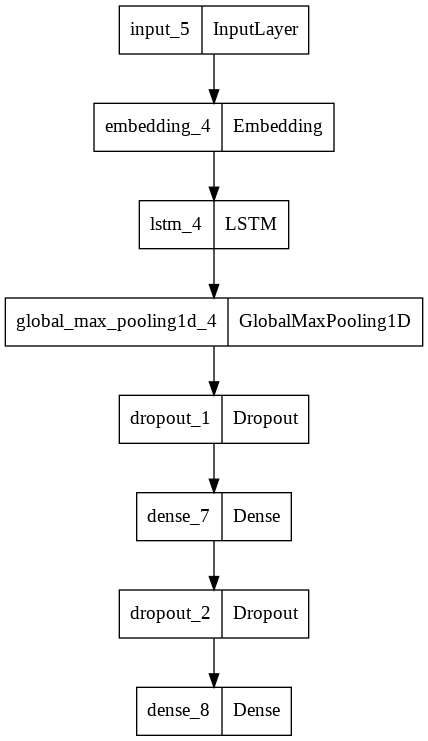

In [29]:
#No GloVe baseline model and one (100, 50) fully connected layer and two dropout layers 0.1
inp = Input(shape=(max_len,))
x = Embedding(max_features,EMBEDDING_DIM)(inp)
x = LSTM(100, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50,activation="relu") (x)
x = Dropout(0.1)(x)
preds = Dense(6,activation="sigmoid") (x)

model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['accuracy'])
plot_model(model)

###Training

In [33]:
print('Training progress:')
history = model.fit(train_texts, train_labels, epochs = 2, batch_size=16, validation_data=(val_texts, val_labels))

Training progress:
Epoch 1/2
3740/3740 [==============================] - 120s 32ms/step - loss: 0.0751 - accuracy: 0.9280 - val_loss: 0.0502 - val_accuracy: 0.9945
Epoch 2/2
3740/3740 [==============================] - 119s 32ms/step - loss: 0.0456 - accuracy: 0.9855 - val_loss: 0.0495 - val_accuracy: 0.9913


###Loss visualizations

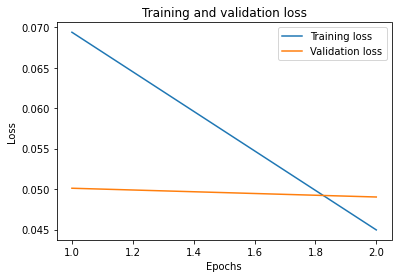

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

### Generate classifications

In [34]:
pred = model.predict(test_texts,batch_size=16,verbose=1)
submission = pd.read_csv("{}/sample_submission.csv".format(BASE_DIR))
submission[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = pred
submission.to_csv('{}/pred.csv'.format(BASE_DIR),index=False)

4787/4787 [==============================] - 39s 8ms/step
